#### Import Libraries

In [135]:
import pandas as pd
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import importlib

# --- INPUTS --- 
# Still need to import correct model 
num_features = 5
model_name = "Deep NN w/ BatchNorm" # "Feed-Forward NN" ; "Deep NN w/ BatchNorm" ; 

# Hyperparameters
batch_size = 64
epochs = 100
lr = 0.001  # 0.001 ; 0.005

# Notes for CSV
hidden_units = "64x2"
architecture_type = "LSTM" # Feed-Forward ; Residual ; LSTM (Long Short-Term Memory) ; GRU (Gated Recurrent Unit) ; TCN (Temporal Convolutional Network)
activation = "tanh/sigmoid" # ReLU ; Tanh
notes_for_model = f"{hidden_units}, {architecture_type}, {activation} activation, {epochs} epochs, lr={lr}"

#### Load Master Data CSV

In [136]:
# Set local data directory
DATA_DIR = '/home/lukeditzler/projects/pytorch/examples/Financial_Markets_Model/data/'
csv_path = os.path.join(DATA_DIR, "historical_finance_data.csv")
master_df = pd.read_csv(csv_path, parse_dates=["Report Date", "Price Date"])
print(f"Original dataframe shape: {master_df.shape}")

# ========== CLEAN DATA: Remove tickers with < 20 quarters ==========
ticker_counts = master_df.groupby("Ticker").size()
valid_tickers = ticker_counts[ticker_counts >= 20].index
removed_tickers = ticker_counts[ticker_counts < 20].index.tolist()

master_df_clean = master_df[master_df["Ticker"].isin(valid_tickers)].copy()

print(f"\nRemoved {len(removed_tickers)} tickers with fewer than 20 quarters:")
print(removed_tickers)
print(f"\nCleaned dataframe shape: {master_df_clean.shape}")
print(f"Number of valid tickers: {len(valid_tickers)}")

Original dataframe shape: (49805, 50)

Removed 1939 tickers with fewer than 20 quarters:
['AAC', 'AACI', 'AACT', 'AAGH', 'AAMC', 'AAN', 'AAON', 'AAWH', 'AAWW', 'ABCL', 'ABIO', 'ABMC', 'ABMD', 'ABML', 'ABNB', 'ABOS', 'ABSI', 'ABTL', 'ACAC', 'ACAH', 'ACAQ', 'ACBA', 'ACBM', 'ACC', 'ACCD', 'ACEL', 'ACER', 'ACET', 'ACHR', 'ACIA', 'ACLX', 'ACN', 'ACOR', 'ACRO', 'ACRV', 'ACTG', 'ACTU', 'ACVA', 'ACXP', 'ADCT', 'ADER', 'ADEX', 'ADMP', 'ADMS', 'ADN', 'ADRT', 'ADTN', 'ADV', 'AE', 'AEHA', 'AEHR', 'AERC', 'AERI', 'AEVA', 'AEYE', 'AFAR', 'AFCG', 'AFI', 'AFIB', 'AFRM', 'AGBA', 'AGFS', 'AGL', 'AGN', 'AHPI', 'AI', 'AILIM', 'AIMC', 'AINC', 'AIP', 'AIRC', 'AIRI', 'AIRS', 'AIRTP', 'AJIA', 'AJRD', 'AKA', 'AKLI', 'AKRX', 'AKS', 'AKTX', 'AKYA', 'ALBO', 'ALCC', 'ALGM', 'ALGS', 'ALHC', 'ALIM', 'ALIT', 'ALJJ', 'ALK', 'ALKT', 'ALLK', 'ALNA', 'ALOT', 'ALPA', 'ALPN', 'ALSK', 'ALTM', 'ALTO', 'ALTR', 'ALUR', 'ALV', 'ALVR', 'ALXN', 'ALXO', 'ALZN', 'AMAM', 'AMCIU', 'AMK', 'AMLX', 'AMPE', 'AMPH', 'AMPL', 'AMPS', 'AMPX'

#### Functions to Process/Prepare the Data

In [137]:
import sys
sys.path.append("../src")  # or correct relative path from notebook
from data_preprocessing import select_top_features, prepare_financial_data_timesplit

# Initial 5 Features
if num_features == 5:
    manual_features = [
        "Revenue",
        "Gross Profit",
        "Operating Income (Loss)",
        "Total Assets",
        "Net Cash from Operating Activities"
    ]
else:
    # N Features Test
    manual_features = select_top_features(master_df, num_features=num_features)
    print(f"Features included: {manual_features}\n")
    

# Prepare data
X_train, y_train, X_test, y_test, features, scaler, train_df, test_df = prepare_financial_data_timesplit(
    master_df_clean, 
    manual_features=manual_features,
    train_ratio=0.8
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(features)}")


Training set size: 24075
Test set size: 6420
Number of features: 5


#### Import Models

In [ ]:
# Import Dataset class
from dataset_class import FinancialDataset

# Import various models
from models.ff_base_v1 import FFBaseV1
from models.ff_residual_v2 import FFResidualV2
from models.lstm_model import FinancialLSTM

# Number of columns/features
input_dim = X_train.shape[1]

# Define model instance - INPUT
model = FFResidualV2(input_dim)
print(model)

# Dataset and DataLoader
train_dataset = FinancialDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Loss Function: MSE
loss_fn = nn.MSELoss()  # regression loss
# Define optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

FinancialLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


#### Training Loop

In [139]:
for epoch in range(1, epochs+1):
    # Reset the loss
    epoch_loss = 0.0

    # Iterate through batches
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)  # sum loss for this batch

    # Average loss for epoch
    epoch_loss /= len(train_dataset)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.6f}")

IndexError: too many indices for tensor of dimension 2

#### Evaluation and Plotting


Generating plots for first 3 tickers...


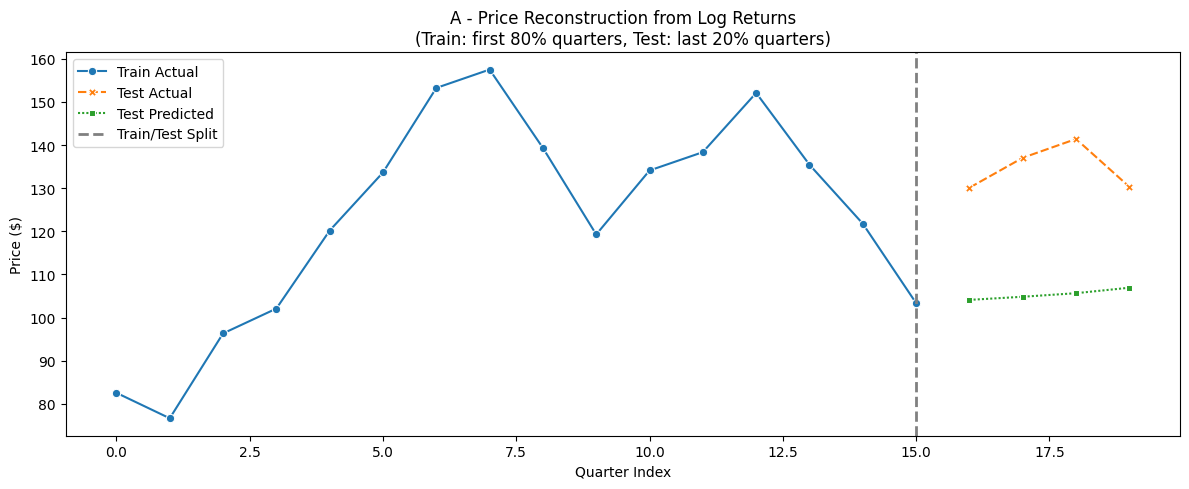

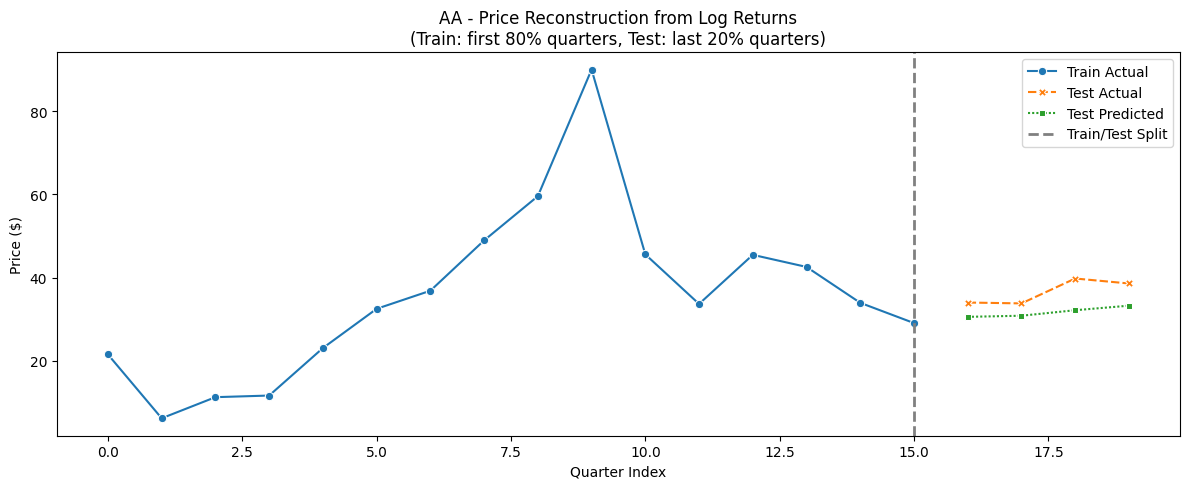

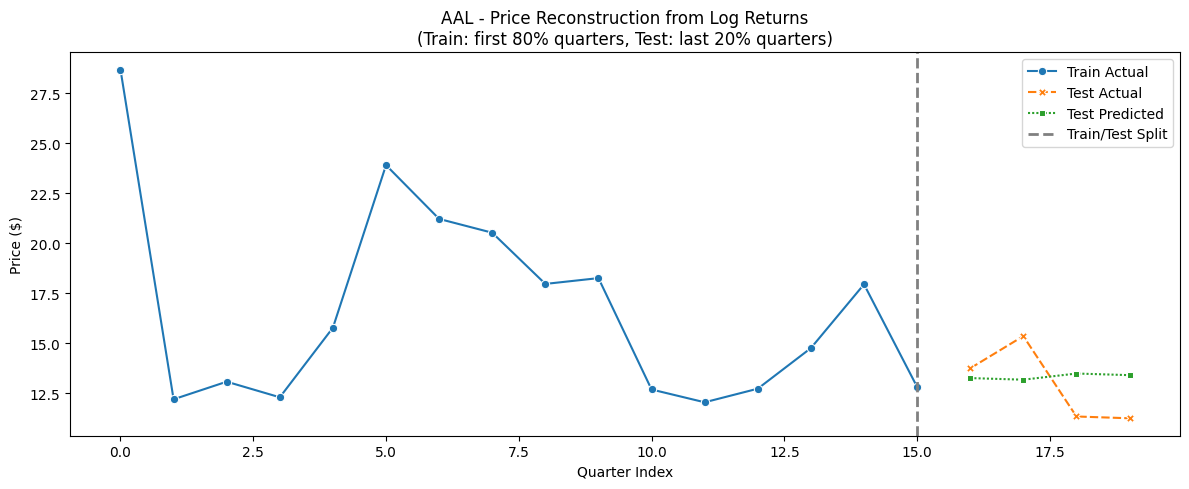

In [ ]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).flatten().numpy()

from plot_predictions import plot_ticker_predictions

# Plot first 5 tickers
print("\nGenerating plots for first 3 tickers...")
unique_tickers = train_df["Ticker"].unique()
for ticker in unique_tickers[:3]:
    plot_ticker_predictions(ticker, train_df, test_df, y_test_pred)

#### Track Model Performance

In [ ]:
# Remove cached module if it exists
if 'model_evaluation' in sys.modules:
    del sys.modules['model_evaluation']

from model_evaluation import evaluate_model, quick_eval
from model_evaluation import ModelPerformanceTracker

# Initialize tracker (will load existing CSV if it exists)
tracker = ModelPerformanceTracker(csv_file="model_results.csv")
print(f"DEBUG: Tracker has {len(tracker.results_df)} rows loaded")

# After training your model:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).flatten().numpy()

# Evaluate and print
metrics = quick_eval(y_test, y_test_pred)
 
# Add to tracker
tracker.add_result(
    model_name=model_name,
    num_features=num_features,
    metrics_dict=metrics,
    notes=notes_for_model
)

# View all results
tracker.print_summary()

Loaded existing results from /home/lukeditzler/projects/pytorch/examples/Financial_Markets_Model/outputs/model_results.csv
Current number of rows: 3

DEBUG: Tracker has 3 rows loaded

Directional Accuracy: 52.38%
Correlation:          0.0170
R² (Variance):        -0.0047

MODEL PERFORMANCE COMPARISON
          Model_Name  Num_Features Directional_Accuracy_% Correlation      R²   RMSE      MAE  N_Predictions                                                                 Notes
     Feed-Forward NN             5                  51.96      0.0421 -0.0293 0.2714 0.178459           6420 256-128-128-64-1, Feed-Forward, ReLU activation, 100 epochs, lr=0.001
     Feed-Forward NN            25                  52.76      0.0122 -0.2286 0.2965 0.183263           6420 256-128-128-64-1, Feed-Forward, ReLU activation, 100 epochs, lr=0.001
Deep NN w/ BatchNorm             5                  48.75     -0.0365 -0.0047 0.2682 0.177657           6420     256-128-128-64-1, Residual, ReLU activation, 100